In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bifacial_geo as geo
import helper
from skopt import gp_minimize
from skopt import plots
from joblib import Parallel, delayed, Memory

In [4]:
def _run(df, land_cost, invest_kwp, bifacial=True):
    simulator = geo.CostOptimizer(
                    df,
                    price_per_m2_land=land_cost,
                    bifacial=bifacial,
                    invest_kwp = invest_kwp)
    simulator.optimize()
    return simulator.res

class ParallelWrapper():
    def __init__(self, location, cache=True):
        self.location = location
        self.df = helper.load_dataframe(self.location)
        self.cache = cache

    def parallel_run(self, land_costs, invest_kwp, location, bifacial=True):
        if self.cache:
            cache_location = './cachedir'
            memory = Memory(cache_location, verbose=0)
            cached_run = memory.cache(_run)

        return Parallel(n_jobs=4)(delayed(cached_run)\
                       (self.df, land_cost, invest_kwp,  bifacial=True)
                       for land_cost in land_costs)

def process_results(results):
    df_dict = {
    'cost': [results[i].fun for i in range(len(results))],
    'dist': [results[i].x[0] for i in range(len(results))],
    'tilt': [results[i].x[1] for i in range(len(results))]
        }

    df = pd.DataFrame(df_dict, index=land_costs)
    df['yield'] = (invest_kwp*0.2*100 + 100*land_costs*df.dist/1.65)/(df.cost*25*0.2)
    df['land_cost'] = (100*land_costs*df.dist/1.65) / (df['yield']*25*0.2)
    df['invest'] = df['cost'] - df['land_cost']
    return df

def plot_objective(result):
    space = result.space
    samples = np.asarray(result.x_iters)
    n_samples=250; levels=20; n_points=40
    rvs_transformed = space.transform(space.rvs(n_samples=n_samples))

    fig, ax = plt.subplots(dpi=150)
    xi, yi, zi = plots.partial_dependence(space, result.models[-1],
                                    1, 0,
                                    rvs_transformed, n_points)
    ax.contourf(xi, yi, zi, levels, cmap='viridis_r')
    ax.scatter(samples[:, 0], samples[:, 1],
                     c='k', s=10, lw=0.)
    ax.scatter(result.x[0], result.x[1],
                     c=['r'], s=20, lw=0.)
    ax.set_ylabel('distance between modules (m)')
    ax.set_xlabel('tilt angle (°)')

In [5]:
land_costs = np.array([1, 2.5, 5 ,10 ,20])
invest_kwp = 1500

location = 'dallas'

wrapper = ParallelWrapper(location)
results_bifacial = wrapper.parallel_run(land_costs, invest_kwp, location)
results_front = wrapper.parallel_run(land_costs, invest_kwp, location, bifacial=False)

stats_bifacial = process_results(results_bifacial)
stats_front = process_results(results_front)

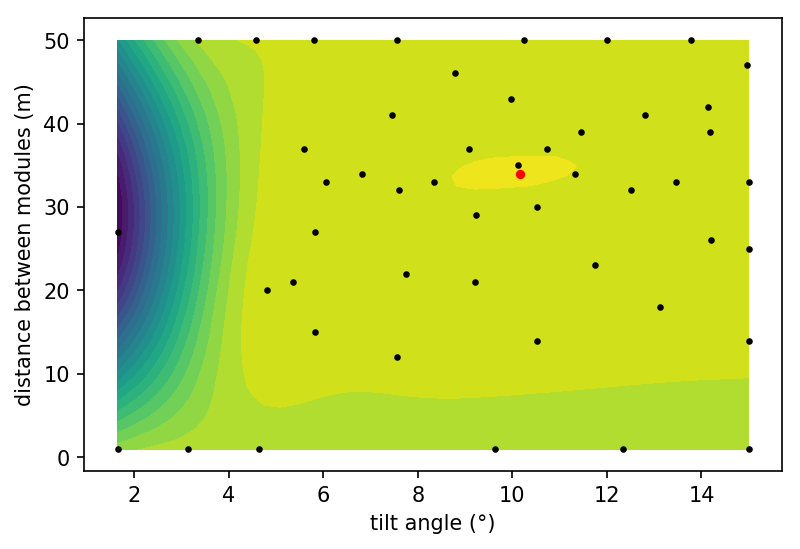

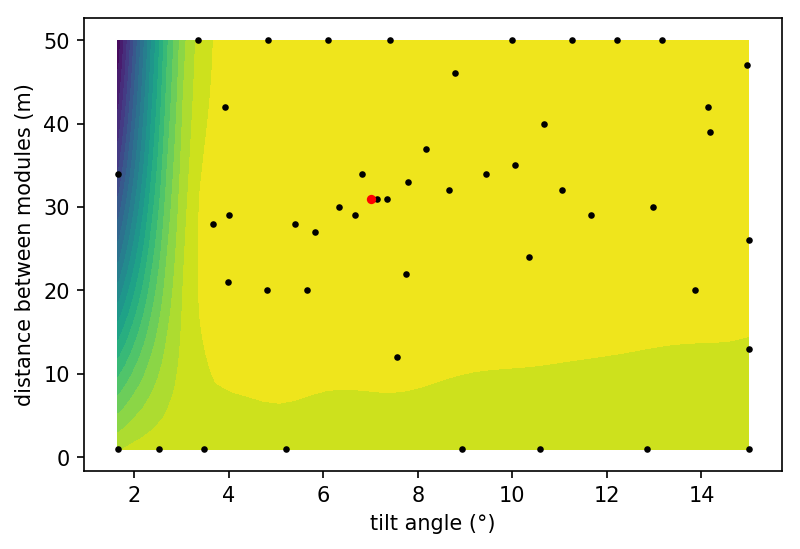

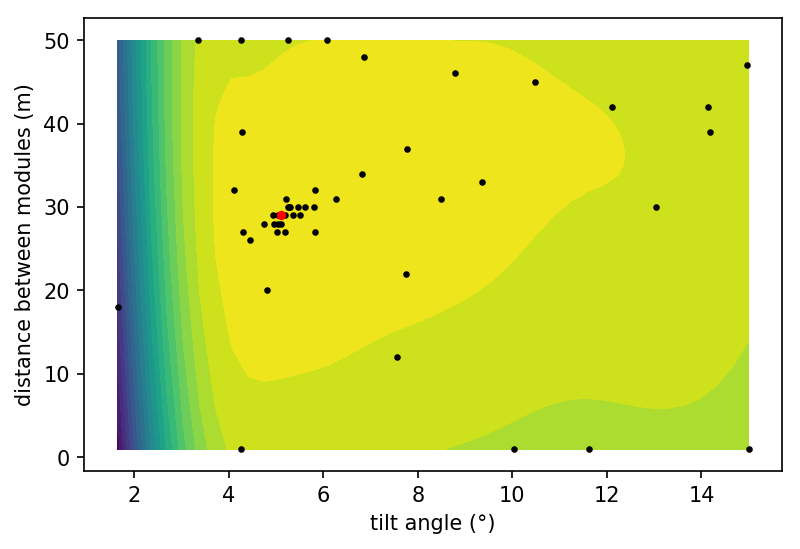

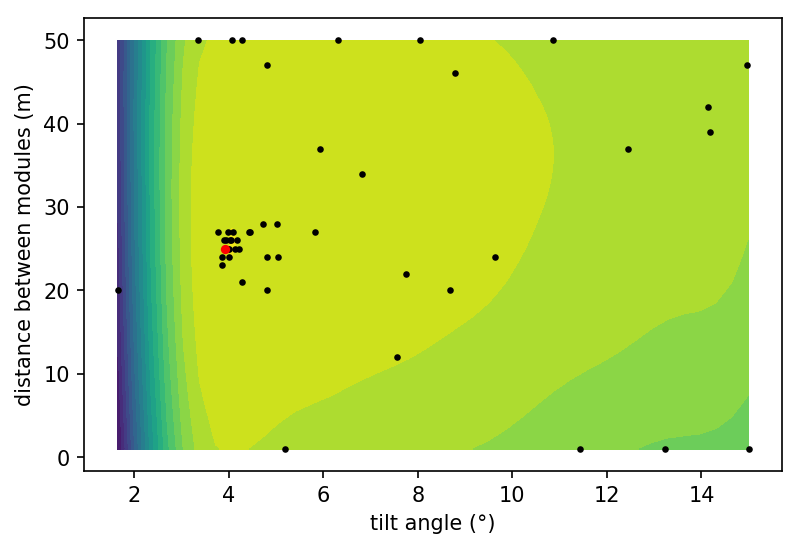

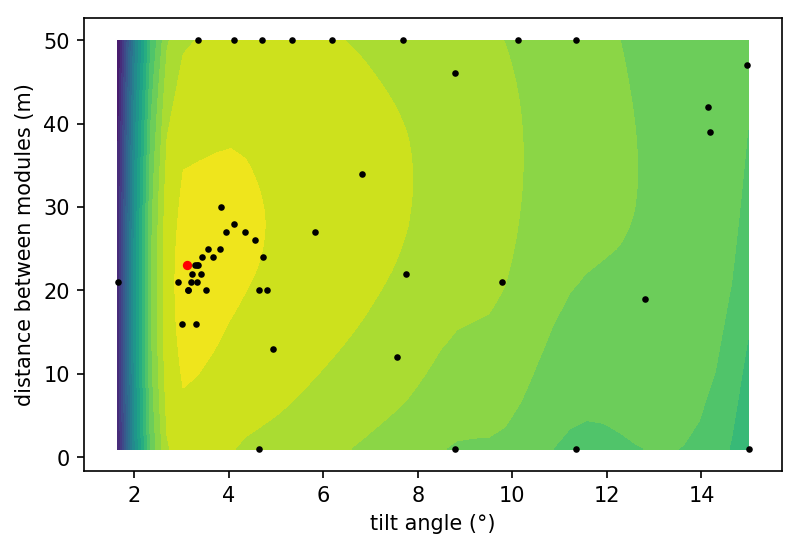

In [6]:
for result in results_bifacial:
    plot_objective(result)

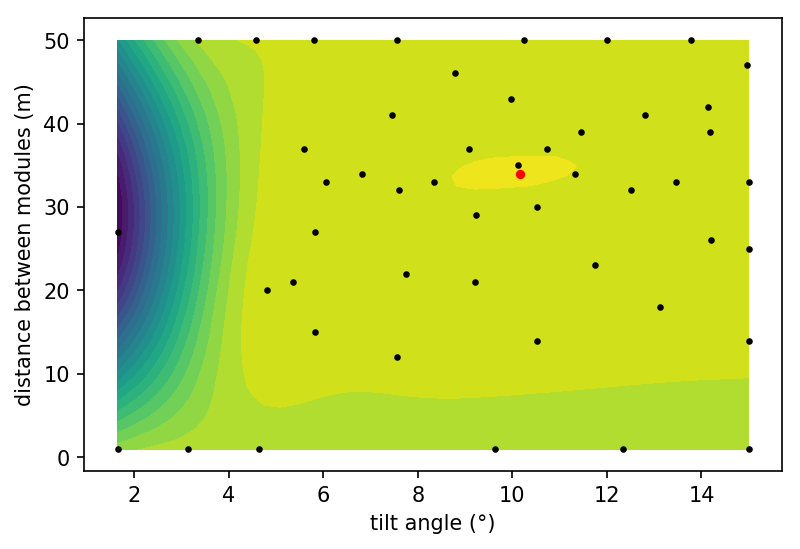

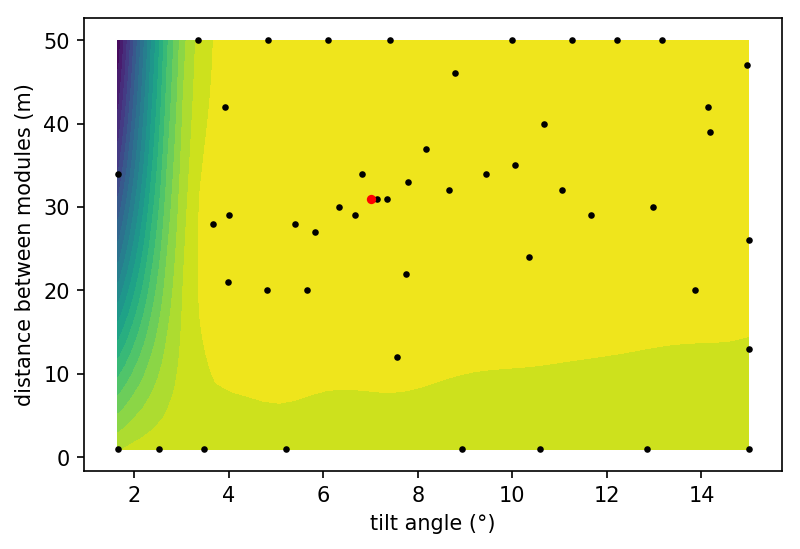

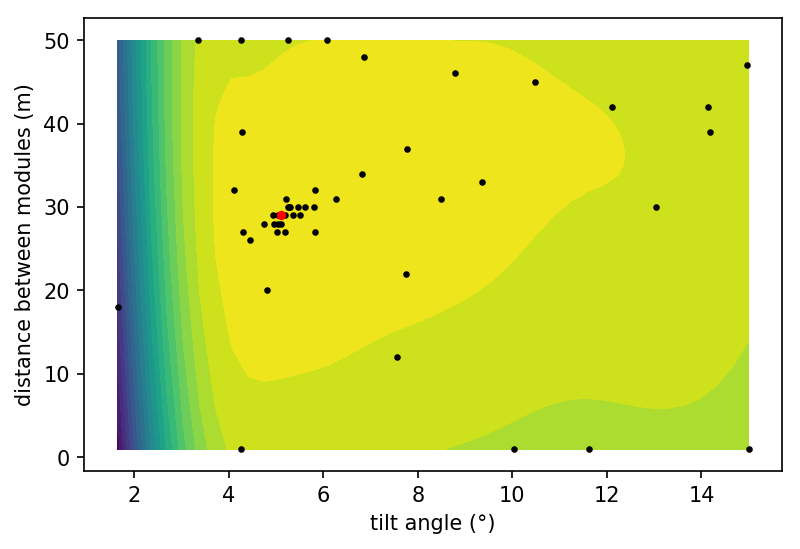

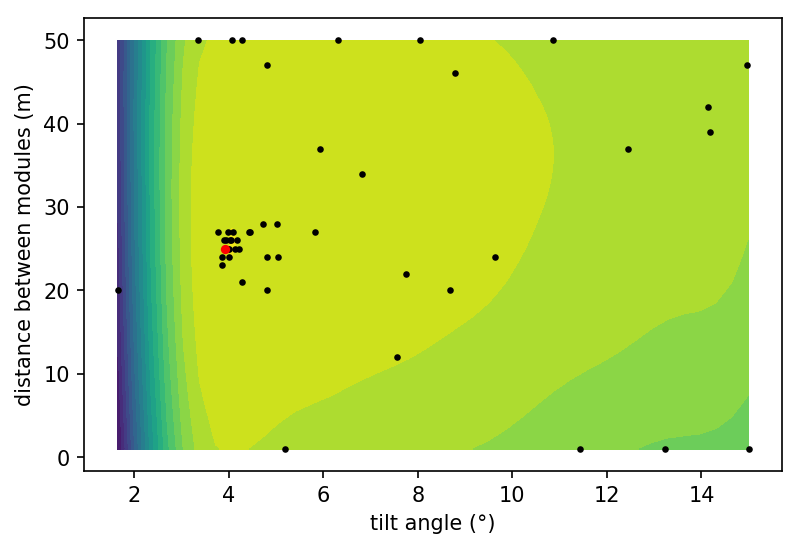

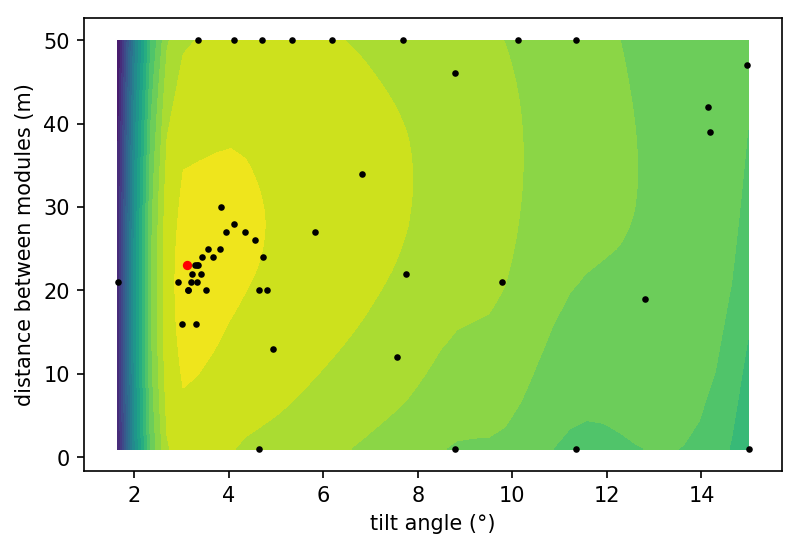

In [7]:
for result in results_front:
    plot_objective(result)